In [1]:
import os
import h5py
import numpy as np
from numba import njit
from itertools import chain
import romspline
from scipy.interpolate import CubicSpline 

def compare_approximate(first, second):
    """Return whether two dicts of arrays are roughly equal"""
    if first.keys() != second.keys():
        return False, 1
        
    return all(np.allclose(first[key], second[key], equal_nan=True) for key in first), 0


In [2]:
PATH = '/home/lorenzo/phd/NS_HOT_EOS/EOS/compOSE/FOP(SFHoY)'
h5_name = 'TEST_' + PATH.split('/')[-1] + '.h5'
OUTPUT = os.path.join(PATH, h5_name)
files = [file for file in os.listdir(PATH) if 'eos.' in file and not '.pdf' in file and not '.init' in file]
# files

files = ['eos.nb', 'eos.thermo', 'eos.t', 'eos.yq', 'eos.compo']

skip_rows = {
                'eos.nb' : 2,
                'eos.thermo' : 1,
                'eos.t' : 2,
                'eos.yq' : 2,
                'eos.compo' : 0
            }

def custom_read(FILE_PATH):

    with open(FILE_PATH, 'r') as f:
        all_data=[x.split() for x in f.readlines()]

    n_cols = max(len(line) for line in all_data)
    n_rows = len(all_data)
    out_arr = np.full((n_rows, n_cols), np.NaN)

    for i, line in enumerate(all_data):
        out_arr[i, :len(line)] = np.array(line, dtype = np.float64)
    
    return out_arr


In [3]:

data = {}
for file in files:
    FILE_PATH = os.path.join(PATH, file)
    try:
        data[file] = np.loadtxt(FILE_PATH, skiprows=skip_rows[file], dtype=np.float64)
        if file == 'eos.thermo':
            with open(FILE_PATH) as f:
                m_n, m_p, _ = np.fromstring(f.readline().strip('\n'), dtype = float, sep='\t')
    except ValueError:
        data[file] = custom_read(FILE_PATH)
    except KeyError:
        print(f'{file} not found!')

    

In [4]:
# Gli indici sono da 1 a N in Fortran, da 0 a N-1 in Python
index_T    = data['eos.thermo'][:, 0].astype(int) - 1
index_nb   = data['eos.thermo'][:, 1].astype(int) - 1
index_yq   = data['eos.thermo'][:, 2].astype(int) - 1

logrho     = np.log10(data['eos.nb'] * m_n)  # log_10( nb * m_n ), nb exponential   MeV / fm^3
pointsrho  = len(logrho)

y_q        = data['eos.yq']                  # LINEARE                 Adimensionale
pointsyq   = len(y_q)

logtemp    = np.log10(data['eos.t'])         # log_10( T ), T exponential           MeV
pointstemp = len(logtemp)

In [5]:
# Map from (i_T, i_nb, i_Ye) to 1D index
def maps(i, j, k, pointsrho, pointsyq):
    """
    Defines a function that maps indices from the original matrix to the reshaped matrix calculating the index in the original matrix corresponding to the given indices in the reshaped matrix.
    """
    return i + pointsrho * pointsyq * j + pointsyq * k

 
def reshape_array(original_matrix, pointsrho, pointstemp, pointsyq):
    """
    Reshapes the original matrix into the desired shape using the maps function.
    """
    indices = maps(np.arange(pointsyq)[:, None, None], np.arange(pointstemp)[None, :, None], np.arange(pointsrho)[None, None, :], pointsrho, pointsyq)
    # Returns the values from the original matrix at the calculated indices
    return np.take(original_matrix, indices)


In [6]:
## COMPUTE PRESSURE, RESHAPE AND TEST FOR EQUIVALENCE!!! Secondo metodo circa 28 volte più veloce del primo

pressure   = data['eos.thermo'][:, 3] * data['eos.nb'][index_nb]   # MeV / fm^3
pp = np.zeros((pointsyq, pointstemp, pointsrho))
for i in range(pointsyq):
    for j in range(pointstemp):
        for k in range(pointsrho):
            pp[i, j, k] = pressure[maps(i,j,k, pointsrho, pointsyq)]

pressure_r = reshape_array(pressure, pointsrho, pointstemp, pointsyq)

##### NEW
pressure_shift = np.abs(np.min([np.min(pressure_r), 0])) * 1.01
pressure_s = pressure_r + pressure_shift
#####

np.testing.assert_allclose(pressure_r, pp)

#############################################
## COMPUTE ENTROPY, RESHAPE AND TEST FOR EQUIVALENCE!!! Secondo metodo circa 28 volte più veloce del primo

entropy    = data['eos.thermo'][:, 4] * data['eos.nb'][index_nb]   # Adimensionale
ee = np.zeros((pointsyq, pointstemp, pointsrho))
for i in range(pointsyq):
    for j in range(pointstemp):
        for k in range(pointsrho):
            ee[i, j, k] = entropy[maps(i,j,k, pointsrho, pointsyq)]

entropy_r = reshape_array(entropy, pointsrho, pointstemp, pointsyq)

np.testing.assert_allclose(entropy_r, ee)

#############################################
## COMPUTE ENERGY, RESHAPE AND TEST FOR EQUIVALENCE!!! Secondo metodo circa 28 volte più veloce del primo
# Se ho capito bene Q7 --> data['eos.thermo'][:, 9] è esattamente "energy" negli h5 (da capire come la scala)
energy     = data['eos.thermo'][:, 9]
en = np.zeros((pointsyq, pointstemp, pointsrho))
for i in range(pointsyq):
    for j in range(pointstemp):
        for k in range(pointsrho):
            en[i, j, k] = energy[maps(i,j,k, pointsrho, pointsyq)]

energy_r = reshape_array(energy, pointsrho, pointstemp, pointsyq)

energy_shift = np.abs(np.min([np.min(energy_r), 0])) * 1.01
energy_s = energy_r + energy_shift

np.testing.assert_allclose(energy_r, en)



logenergy = np.log10(energy_s)
logpress = np.log10(pressure_s)

# $c_s^2$ and $\gamma$ (if the derivative is correct)

# Spline

In [7]:
e = m_n * data['eos.nb'][index_nb] * ( 1 + data['eos.thermo'][:, 9] )
e_r = reshape_array(e, pointsrho, pointstemp, pointsyq)

In [27]:
dpdnb = np.zeros_like(e_r)
dednb = np.zeros_like(e_r)
dpdt = np.zeros_like(e_r)
dedt = np.zeros_like(e_r)
dpdy = np.zeros_like(e_r)
dedy = np.zeros_like(e_r)

order = 1

for i in range(pointsyq):
    for j in range(pointstemp):
        dpdnb[i, j, :] = CubicSpline(data['eos.nb'], pressure_s[i, j, :]).derivative(nu=order)(data['eos.nb'])
        dednb[i, j, :] = CubicSpline(data['eos.nb'], e_r[i, j, :]).derivative(nu=order)(data['eos.nb'])

for i in range(pointsyq):
    for j in range(pointsrho):
        dpdt[i, :, j] = CubicSpline(data['eos.t'], pressure_s[i, :, j]).derivative(nu=order)(data['eos.t'])
        dedt[i, :, j] = CubicSpline(data['eos.t'], e_r[i, :, j]).derivative(nu=order)(data['eos.t'])

for i in range(pointstemp):
    for j in range(pointsrho):
            dpdy[:, i, j] = CubicSpline(data['eos.yq'], pressure_s[:, i, j]).derivative(nu=order)(data['eos.yq'])
            dedy[:, i, j] = CubicSpline(data['eos.yq'], e_r[:, i, j]).derivative(nu=order)(data['eos.yq'])

cs2_spline = dpdnb/dednb + dpdt/dedt + dpdy/dedy

In [26]:
def first_derivative(y, x):
  return CubicSpline(x, y).derivative(nu=1)(x)

dpdnb_2 = np.apply_along_axis(first_derivative, 2, pressure_s, data['eos.nb'])
dednb_2 = np.apply_along_axis(first_derivative, 2, e_r       , data['eos.nb'])
dpdt_2  = np.apply_along_axis(first_derivative, 1, pressure_s, data['eos.t'] )
dedt_2  = np.apply_along_axis(first_derivative, 1, e_r       , data['eos.t'] )
dpdy_2  = np.apply_along_axis(first_derivative, 0, pressure_s, data['eos.yq'])
dedy_2  = np.apply_along_axis(first_derivative, 0, e_r       , data['eos.yq'])

cs2_spline_2 = dpdnb_2/dednb_2 + dpdt_2/dedt_2 + dpdy_2/dedy_2

In [28]:
np.testing.assert_allclose(cs2_spline, cs2_spline_2)

## Standard

In [12]:
e = m_n * data['eos.nb'][index_nb] * ( 1 + data['eos.thermo'][:, 9] )
e_r = reshape_array(e, pointsrho, pointstemp, pointsyq)

dpdnb = np.zeros_like(e_r)
dednb = np.zeros_like(e_r)
for i in range(pointsyq):
    for j in range(pointstemp):
        for k in range(pointsrho-1):
            h = data['eos.nb'][k+1] - data['eos.nb'][k]
            dpdnb[i, j, k] = (pressure_s[i, j, k+1] - pressure_s[i, j, k]) / ( h )
            dednb[i, j, k] = (e_r[i, j, k+1] - e_r[i, j, k]) / ( h )

dpdt = np.zeros_like(e_r)
dedt = np.zeros_like(e_r)
for i in range(pointsyq):
    for j in range(pointsrho):
        for k in range(pointstemp-1):
            h = data['eos.t'][k+1] - data['eos.t'][k]
            dpdt[i, k, j] = (pressure_s[i, k+1, j] - pressure_s[i, k, j]) / ( h )
            dedt[i, k, j] = (e_r[i, k+1, j] - e_r[i, k, j]) / ( h )

dpdy = np.zeros_like(e_r)
dedy = np.zeros_like(e_r)
for i in range(pointstemp):
    for j in range(pointsrho):
        for k in range(pointsyq-1):
            h = data['eos.yq'][k+1] - data['eos.yq'][k]
            dpdy[k, i, j] = (pressure_s[k+1, i, j] - pressure_s[k, i, j]) / ( h )
            dedy[k, i, j] = (e_r[k+1, i, j] - e_r[k, i, j]) / ( h )

cs2 = dpdnb/dednb + dpdt/dedt + dpdy/dedy

/tmp/ipykernel_284/3473401020.py:31: RuntimeWarning: divide by zero encountered in divide
  cs2 = dpdnb/dednb + dpdt/dedt + dpdy/dedy
/tmp/ipykernel_284/3473401020.py:31: RuntimeWarning: invalid value encountered in divide
  cs2 = dpdnb/dednb + dpdt/dedt + dpdy/dedy
/tmp/ipykernel_284/3473401020.py:31: RuntimeWarning: invalid value encountered in add
  cs2 = dpdnb/dednb + dpdt/dedt + dpdy/dedy


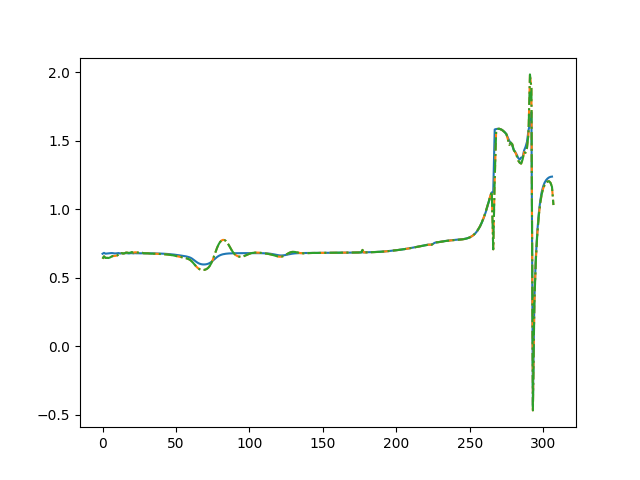

In [42]:
import matplotlib.pyplot as plt
%matplotlib widget

fig = plt.figure()
plt.plot(cs2[0,0,:])
plt.plot(cs2_spline[0,0,:], '--')
plt.plot(cs2_spline_2[0,0,:], '-.')

In [14]:
dlnpdnb = np.zeros_like(e_r)
dlnednb = np.zeros_like(e_r)
for i in range(pointsyq):
    for j in range(pointstemp):
        for k in range(pointsrho-1):
            h = data['eos.nb'][k+1] - data['eos.nb'][k]
            dlnpdnb[i, j, k] = (np.log(pressure_s[i, j, k+1]) - np.log(pressure_s[i, j, k])) / ( h )
            dlnednb[i, j, k] = (np.log(e_r[i, j, k+1]) - np.log(e_r[i, j, k])) / ( h )

dlnpdt = np.zeros_like(e_r)
dlnedt = np.zeros_like(e_r)
for i in range(pointsyq):
    for j in range(pointsrho):
        for k in range(pointstemp-1):
            h = data['eos.t'][k+1] - data['eos.t'][k]
            dlnpdt[i, k, j] = (np.log(pressure_s[i, k+1, j]) - np.log(pressure_s[i, k, j])) / ( h )
            dlnedt[i, k, j] = (np.log(e_r[i, k+1, j]) - np.log(e_r[i, k, j])) / ( h )

dlnpdy = np.zeros_like(e_r)
dlnedy = np.zeros_like(e_r)
for i in range(pointstemp):
    for j in range(pointsrho):
        for k in range(pointsyq-1):
            h = data['eos.yq'][k+1] - data['eos.yq'][k]
            dlnpdy[k, i, j] = (np.log(pressure_s[k+1, i, j]) - np.log(pressure_s[k, i, j])) / ( h )
            dlnedy[k, i, j] = (np.log(e_r[k+1, i, j]) - np.log(e_r[k, i, j])) / ( h )

gamma = dlnpdnb/dlnednb + dlnpdt/dlnedt + dlnpdy/dlnedy
gamma_cs2 = e_r * cs2 / pressure_s

# np.testing.assert_allclose(gamma, gamma_cs2)

/tmp/ipykernel_284/3005701431.py:8: RuntimeWarning: invalid value encountered in log
  dlnednb[i, j, k] = (np.log(e_r[i, j, k+1]) - np.log(e_r[i, j, k])) / ( h )
/tmp/ipykernel_284/3005701431.py:17: RuntimeWarning: invalid value encountered in log
  dlnedt[i, k, j] = (np.log(e_r[i, k+1, j]) - np.log(e_r[i, k, j])) / ( h )
/tmp/ipykernel_284/3005701431.py:26: RuntimeWarning: invalid value encountered in log
  dlnedy[k, i, j] = (np.log(e_r[k+1, i, j]) - np.log(e_r[k, i, j])) / ( h )
/tmp/ipykernel_284/3005701431.py:28: RuntimeWarning: divide by zero encountered in divide
  gamma = dlnpdnb/dlnednb + dlnpdt/dlnedt + dlnpdy/dlnedy
/tmp/ipykernel_284/3005701431.py:28: RuntimeWarning: invalid value encountered in divide
  gamma = dlnpdnb/dlnednb + dlnpdt/dlnedt + dlnpdy/dlnedy
/tmp/ipykernel_284/3005701431.py:28: RuntimeWarning: invalid value encountered in add
  gamma = dlnpdnb/dlnednb + dlnpdt/dlnedt + dlnpdy/dlnedy


# Mass fractions $X_i$

In [15]:
particle_index = {
    0    : 'e',
    10   : 'n',
    11   : 'p',
    100  : 'Λ',
    110  : 'Σ−',
    111  : 'Σ0',
    112  : 'Σ+',
    120  : 'Ξ−',
    121  : 'Ξ0',
    4002 : '24He',
    3002 : '23He',
    3001 : '13H',
    2001 : '12H', 
    999  : 'other'
}
particle_index_inv = {v: k for k,v in particle_index.items()}

baryonic_number = {
    0  : 0,
    10 : 1,
    11 : 1,
    100 : 1,
    110 : 1,
    111 : 1,
    112 : 1,
    120 : 1,
    121 : 1,
    4002 : 4,
    3002 : 3,
    3001 : 3,
    2001 : 2,
}


In [16]:
mass_fractions = {}
for i, row in enumerate(data['eos.compo']):
    n_pairs = int(row[4])
    n_quads = int(row[5 + n_pairs * 2])
    
    for j in range(5, 5 + n_pairs * 2, 2):
        particle = int(row[j])
        try:
            mass_fractions[f'X{particle_index[particle]}'][i] = row[j+1] * baryonic_number[particle]
        except KeyError:
            mass_fractions[f'X{particle_index[particle]}'] = np.full(len(data['eos.compo']), np.NaN)
            mass_fractions[f'X{particle_index[particle]}'][i] = row[j+1] * baryonic_number[particle]
    
    if n_quads > 0:
        for j in range(5 + n_pairs * 2 + 1, 5 + n_pairs * 2 + n_quads * 4, 4):
            particle = int(row[j])
            try:
                mass_fractions[f'X{particle_index[particle]}'][i] = row[j+1] * row[j+3]
            except KeyError:
                mass_fractions[f'X{particle_index[particle]}'] = np.full(len(data['eos.compo']), np.NaN)
                mass_fractions[f'X{particle_index[particle]}'][i] = row[j+1] * row[j+3]
for key in mass_fractions.keys():
    mass_fractions[key] = reshape_array(mass_fractions[key], pointsrho, pointstemp, pointsyq)

In [17]:
mass_fractions_2 = {}
for i, row in enumerate(data['eos.compo']):
    # Extract the number of pairs and quads from the current row
    n_pairs_2 = int(row[4])
    n_quads_2 = int(row[5 + n_pairs_2 * 2])

    conc_iter = chain(range(5, 5 + n_pairs_2 * 2, 2), range(5 + n_pairs_2 * 2 + 1, 5 + n_pairs_2 * 2 + 1 + n_quads_2 * 4, 4))
    # Iterate through the pairs and quads
    for j in conc_iter:
        # Get the particle_2
        particle_2 = int(row[j])
        # If j is within the range of the pairs, get its mass fraction
        if j < 5 + n_pairs_2 * 2:
            mass_fraction_2 = row[j+1] * baryonic_number[particle_2]
        # If j is within the range of the quads, get its mass fraction
        else:
            mass_fraction_2 = row[j+1] * row[j+3]
        
        # Try to add the mass fraction to the mass_fractions_2 dictionary
        # If the particle_2 is not already in the dictionary, create a new entry
        # with a default value of NaN for all indices
        try:
            mass_fractions_2[f'X{particle_index[particle_2]}'][i] = mass_fraction_2
        except KeyError:
            mass_fractions_2[f'X{particle_index[particle_2]}'] = np.full(len(data['eos.compo']), np.NaN)
            mass_fractions_2[f'X{particle_index[particle_2]}'][i] = mass_fraction_2

for key in mass_fractions_2.keys():
    mass_fractions_2[key] = reshape_array(mass_fractions_2[key], pointsrho, pointstemp, pointsyq)

In [18]:

print(compare_approximate(mass_fractions, mass_fractions_2))

(True, 0)


# Chemical Potential

In [19]:
free_energy = data['eos.thermo'][:, 9]
free_energy = reshape_array(free_energy, pointsrho, pointstemp, pointsyq)

In [41]:
mus = {}

for key in particle_index.keys():
    if key == 999:
        continue

    mu_lbl = f'mu_{particle_index[key]}'
    X_lbl  = f'X{particle_index[key]}'
    mus[mu_lbl] = reshape_array(np.full(len(data['eos.compo']), np.NaN), pointsrho, pointstemp, pointsyq)
    
    for i in range(pointstemp):
        for j in range(pointsrho):
            for k in range(pointsyq-1):
                mus[mu_lbl][k, i, j] = baryonic_number[key] * ( free_energy[k+1, i, j] - free_energy[k, i, j] ) / (mass_fractions[X_lbl][k+1, i, j] - mass_fractions[X_lbl][k, i, j] ) / data['eos.nb'][j]

/tmp/ipykernel_284/3199410053.py:14: RuntimeWarning: invalid value encountered in double_scalars
  mus[mu_lbl][k, i, j] = baryonic_number[key] * ( free_energy[k+1, i, j] - free_energy[k, i, j] ) / (mass_fractions[X_lbl][k+1, i, j] - mass_fractions[X_lbl][k, i, j] ) / data['eos.nb'][j]
/tmp/ipykernel_284/3199410053.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  mus[mu_lbl][k, i, j] = baryonic_number[key] * ( free_energy[k+1, i, j] - free_energy[k, i, j] ) / (mass_fractions[X_lbl][k+1, i, j] - mass_fractions[X_lbl][k, i, j] ) / data['eos.nb'][j]
/tmp/ipykernel_284/3199410053.py:14: RuntimeWarning: overflow encountered in double_scalars
  mus[mu_lbl][k, i, j] = baryonic_number[key] * ( free_energy[k+1, i, j] - free_energy[k, i, j] ) / (mass_fractions[X_lbl][k+1, i, j] - mass_fractions[X_lbl][k, i, j] ) / data['eos.nb'][j]


### Si rompe quando incontra un nan in mass_fractions

In [21]:
# # Create an array of shape (pointsyq, pointstemp, pointsrho) filled with NaN values
# mus_2 = {}

# # Iterate over the particle species
# for key in particle_index.keys():
#   if key == 999:
#     continue
  
#   lbl = f'mu_{particle_index[key]}'
#   mus_2[lbl] = reshape_array(np.full(len(data['eos.compo']), np.NaN), pointsrho, pointstemp, pointsyq)

#   for i in range(pointstemp):
#     for j in range(pointsrho):
#       # Create a cubic spline for the free energy and mass fractions along the pointsyq axis
#       free_energy_spline = CubicSpline(np.arange(pointsyq), free_energy[:, i, j]).derivative()(np.arange(pointsyq))
#       mass_fractions_spline = CubicSpline(np.arange(pointsyq), mass_fractions[lbl][:, i, j]).derivative()(np.arange(pointsyq))
  
#       # Compute the differences using the splines
#       mus_2[lbl][:, i, j] = baryonic_number[key] * free_energy_spline / mass_fractions_spline / data['eos.nb'][0]

In [22]:
# print(compare_approximate(mus, mus_2))

# Tutto insieme:

In [38]:
ds = {  
        'logrho'   : logrho   , 'pointsrho'     : pointsrho, 
        'y_q'      : y_q      , 'pointsyq'      : pointsyq, 
        'logtemp'  : logtemp  , 'pointstemp'    : pointstemp, 
        'logpress_shifted' : logpress , 'pressure_shift': pressure_shift, 'logpress' : np.log10(pressure_r),
        'entropy'  : entropy_r, 
        'logenergy': logenergy, 'energy_shift'  : energy_shift,
        'cs2'      : cs2      , 'cs2_spline'    : cs2_spline,      'gamma'         : gamma
    }

for key in mass_fractions_2.keys():
    ds[key] = mass_fractions_2[key]
for key in mus.keys():
    ds[key] = mus[key]

/tmp/ipykernel_284/3595886807.py:5: RuntimeWarning: invalid value encountered in log10
  'logpress_shifted' : logpress , 'pressure_shift': pressure_shift, 'logpress' : np.log10(pressure_r),


In [39]:
os.system(f'rm {OUTPUT}')

with h5py.File(OUTPUT, "w") as f:
    for d in ds:
        dset = f.create_dataset(d, data=ds[d], dtype=np.float64)

sh: 1: Syntax error: "(" unexpected
